In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.core.display import HTML
from sklearn.impute import SimpleImputer
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))
plt.rc("font", size=14)
plt.rc("text", usetex=True)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from re import search
%matplotlib inline

In [2]:
def drop_singular_columns(df):
    #Determine the number of samples with the most frequent value; if it equals the number of samples, then drop this column.
    columns = df.columns.values
    columns_to_drop = columns[[len(df)==df[col].value_counts().max() for col in columns]]
    print('Dropping', columns_to_drop, 'column(s) from DataFrame.')
    return df.drop(columns=columns_to_drop)

# Multi-stage recommendation system for capital recovery: Data Cleaning

The main goal of this project is to create two predictive models that combine to form a multi-stage recommendation system
for the preservation and or recovery of capital. The first model is a classification model that predicts whether or not a loan
will be "Charged-off".

### Three stages of data cleaning

    1. Ensure the integrity of the data for use in exploratory data analysis (EDA)
    2. Subset and process the data relevant for the loan-outcome classification problem
    3. Subset and process the data relevant for the recovery-amount regression problem
    
This notebook is focused on cleaning and selecting subsets of the data for different purposes. Any preprocessing
required for application of ML algorithms is left for separate notebooks.

### 1. Data cleaning for use in exploratory data analysis (EDA)

This doesn't require much as we simply want to ensure the integrity of the data; the data comes in '.csv' format
so let us see if it can be imported into a Pandas DataFrame object.

In [3]:
loan_data = pd.read_csv('loan.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Pandas allows for features (columns) to have non-uniform data types, represented by the general category 'object' dtype.
Still, we want the dtypes to be uniform to ensure that any manipulations or transformations later on do not cause errors.

An example of a problem that could arise: imagine a feature includes strings and lists of strings. Attempting to apply
a string based operation such as Python's "split()" method would return an error, as lists do not have the aforementioned attribute. 

Need to deal with mixed dtype columns to make the data consistent and  but first let's see if any of these columns survive the initial processing to remove
columns with majority of missing values.

In [4]:
# Save the column names from DTypeWarning. Need to clean by converting to one data type. 
mixed_dtype_column_names = loan_data.columns[[19,47,55,112,123,124,125,128,129,130,133,139,140,141]]

To try to ascertain the cause of this mixed dtype error, let's look at some of the values in these columns.

In [5]:
loan_data.columns[[19,47,55,112,123,124,125,128,129,130,133,139,140,141]]

Index(['desc', 'next_pymnt_d', 'verification_status_joint',
       'sec_app_earliest_cr_line', 'hardship_type', 'hardship_reason',
       'hardship_status', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_loan_status',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

In [6]:
loan_data.loc[:, mixed_dtype_column_names].tail(10)

,desc,next_pymnt_d,verification_status_joint,sec_app_earliest_cr_line,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,debt_settlement_flag_date,settlement_status,settlement_date
2260658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260659,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260660,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260661,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260662,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260663,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260664,NaN,NaN,Not Verified,Apr-2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260665,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260666,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260667,NaN,Mar-2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like the mixed dtypes are likely due to a mixture of NumPy's NaN value with strings. 
Because the features are in essence categorical, the NaN values can be replaced with a new category, 'Missing';
this applies to all object dtype columns

We need to eventually reorder the data by date and it doesn't affect any calculations so it's done now.

In [7]:
issued_datetime = pd.to_datetime(loan_data.issue_d)
loan_data = loan_data.loc[issued_datetime.sort_values().index,:]

In [8]:
categorical_data = loan_data.select_dtypes(include='object')

To ensure that the guess for the reason for mixed dtypes was right,
check and see that all of these columns with NaN being replaced can undergo a string
concatenation operation; I believe this ensure that all elements are strings. 

In [9]:
categorical_data.apply(lambda x : x+'').head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
2142001,36 months,C,C3,"Stanford University Libraries, LOCKSS Project",< 1 year,RENT,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2142017,36 months,B,B3,NaN,< 1 year,RENT,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2142016,36 months,B,B4,Halping hands company inc.,< 1 year,RENT,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2142015,36 months,C,C1,NaN,< 1 year,RENT,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2142014,36 months,B,B4,Air Force,< 1 year,RENT,Not Verified,Jun-2007,Does not meet the credit policy. Status:Charge...,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN


Next we investigate any required manipulations of the numerical data.

In [10]:
numerical_data = loan_data.select_dtypes(exclude=['object'])

In [11]:
# Summation of all missing values
number_of_missing_values = loan_data.isna().sum().sum()
print('There are {} missing values'.format(number_of_missing_values))
print('This represents {0:.2f}% of the data set.'.format(100*number_of_missing_values/loan_data.size))

There are 108666955 missing values
This represents 33.15% of the data set.


There were not any importation warnings in regards to the numerical columns; but because the categorical variables were missing values it is likely that the numerical data is also missing values. First let's see how many values are indeed missing.

In [12]:
# Summation of all missing values
number_of_missing_values = numerical_data.isna().sum().sum()
print('There are {} missing values'.format(number_of_missing_values))
print('This represents {0:.2f}% of this data.'.format(100*number_of_missing_values/numerical_data.size))

There are 78158211 missing values
This represents 31.72% of this data.


Another interesting question, how are these missing variables distributed? Is it uniform across all features?

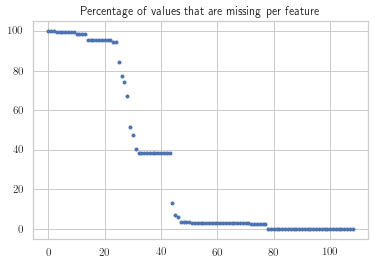

In [13]:
# Plot of the percentage of values that are missing per feature as a monotonically decreasing sequence
percentnan = numerical_data.isna().sum().sort_values(ascending=False) / len(numerical_data)
plt.plot(100*percentnan.values, marker='.',linestyle='none')
plt.title('Percentage of values that are missing per feature')
plt.show()

The majority of features are missing values; this is a problem for some of scikit-learn's machine learning algorithms we
want to use; therefore, we need to figure out how to deal with them. We can not simply drop all rows (samples) which have missing values as this would leave us with exactly 0 samples:

In [14]:
numerical_data.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Columns: 109 entries, id to settlement_term
dtypes: float64(105), int64(4)
memory usage: 0.0 bytes


Columns missing literally every value are worthless; so we drop them. There would be an argument to make that perhaps this is representative of sampling bias but because the sample is so large this is almost surely not the case.

In [15]:
missing_value_percentages = 100 * numerical_data.isna().sum() / len(numerical_data)
missing_value_percentages[missing_value_percentages==100.0]

id           100.0
member_id    100.0
url          100.0
dtype: float64

In [16]:
categorical_data = categorical_data.fillna(value='Missing')
loan_data = pd.concat((numerical_data, categorical_data),axis=1)

In [17]:
loan_data = loan_data.drop(columns=['id','member_id','url'])

 A similar situation is the columns which only have a single value; note that Pandas does not consider missing values as a "value" so a distinction needs to be made between literally every sample having the same value features containing a single value and missing values.

The distinction between these two types is motivated by the concept of sampling bias. When we train our models with columns which follow the same pattern as 'policy_code', the model will only train on a single value and as such won't be good models for new test data with different values. In other words, the training domain doesn't encapsulate the testing domain and as such the model will have trouble with such predictions.

First, determine and drop the columns which only have a single unique value.

In [18]:
loan_data = drop_singular_columns(loan_data)

Dropping ['policy_code'] column(s) from DataFrame.


There are also certain data whose purpose is to merely contribute noise to the data set. These features have a large number of personalized responses; creating categorical data with a large number of categories. This information could be
encoded into a sparse matrix, or tools from natural language processing (NLP) could be applied, but we reject these choices as
they do not seem very efficient or useful at the moment.

Another reason to do this is because later in the cross validation stage of the modeling process, we would like to only have variables where we know their categories a priori so that they can be encoded 

In [19]:
idiosyncratic_columns = ['emp_title', 'desc', 'title']
loan_data = loan_data.drop(columns=idiosyncratic_columns)

There are still missing values in the dataset; but the approach with which to replace these values depends on the calculation
being performed and so these values are kept until they need to be replaced or removed.

In [ ]:
loan_data.to_csv('loan_data_eda.csv', index=False)

### 2. Data cleaning and preprocessing for loan outcome classification problem.

The current formulation of this problem is to predict whether or not a loan will be charged off by the time it matures. Therefore, we separate out the data for the loans that have already matured by comparing the most recent date in the dataset
to the maturity date. The maturity date is equal to the date the loan was issued added to the length of the loan.

Want to convert the loan status into a binary variable; label the loans which have been charged off as positive
outcome and otherwise as negative. This begs the question; should the data be separated into loans that have past their
maturity date? The outcome of a current loan is a nonsensical quantity. Because the answer is not known let's account for both cases. Save the index when subsetting the data so other dataframes can be sliced equivalently.

In [72]:
# Convert 'Term' from string to integer years; strings are either ' 36 Months' or ' 60 Months' (note the leading whitespace)
terms_num = categorical_data.term.str.split(' ').apply(lambda x: int(x[1])//12)

issued_date = pd.to_datetime(categorical_data.issue_d)
maturity_date = issued_date.copy()

# Select the indices for 3 and 5 year loans
year3index = terms_num[terms_num.values==3].index
year5index = terms_num[terms_num.values==5].index

# Maturity Date = Term + Issued date 
maturity_date.loc[year3index] = issued_date.loc[year3index] + pd.DateOffset(years=3)
maturity_date.loc[year5index] = issued_date.loc[year5index] + pd.DateOffset(years=5)

# The matured loans are those whose maturity date is less than the most recent date, December 1st, 2018.
matured_loan_data = loan_data.loc[maturity_date[maturity_date < pd.to_datetime('2018-12-02')].index, :]

In [73]:
classification_data = matured_loan_data[matured_loan_data.loan_status.isin(['Charged Off','Fully Paid'])]

Can safely overwrite/transform values to binary that we want for logistic regression because we have made a copy specifically
for the classification problem.

In [74]:
binary_loan_status = classification_data.loan_status.map({'Fully Paid': 0, 'Charged Off': 1})
classification_data = classification_data.assign(loan_status=binary_loan_status)

Because a subset of the data was taken; ensure that there are no features with a single value again. 

In [75]:
classification_data = drop_singular_columns(classification_data)

Dropping ['out_prncp' 'out_prncp_inv' 'pymnt_plan' 'next_pymnt_d'
 'sec_app_earliest_cr_line' 'hardship_flag' 'disbursement_method'] column(s) from DataFrame.


Because we are trying to predict whether or not to *issue* a loan, only data that is available at the time of
that decision can be used in the creation of the predictive model. This will exclude variables which aggregate data
from the past X months from the present date. The metadata or explanation of the variables typically indicates when the quantity involves time, so we take advantage of this by keeping anything that doesn't include terms like "current" or "past X months", etc. 

The list of variables included in the modeling process:
    
    1. Loan amount
    2. Funded amount
    3. Funded amount from investors
    4. Interest rate
    5. Installment
    6. Annual income
    7. Term
    8. Grade
    9. Sub-grade
    10. Length of time at current employer
    11. Home ownership status
    12. Verification status
    13. Issuance date
    14. Purpose
    15. Zip code
    16. State of residence
    17. Earliest date of recorded credit line
    18. Initial listing status
    19. Application type
    20. Joint verification status
    
And of course, the target variable; the outcome of the loan.

In [76]:
percent_nan = classification_data.isna().sum().sort_values(ascending=False)[:10] / len(classification_data)
percent_nan_to_remove = percent_nan[percent_nan > 0.99].index

In [77]:
percent_nan_to_remove

Index(['sec_app_inq_last_6mths', 'revol_bal_joint',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'sec_app_open_act_il',
       'sec_app_revol_util', 'sec_app_open_acc', 'sec_app_mort_acc',
       'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths'],
      dtype='object')

In [78]:
classification_data = classification_data.loc[:, ~classification_data.columns.isin(percent_nan_to_remove.tolist())]

In [79]:
classification_data.isna().sum().sort_values(ascending=False)[:10] / len(classification_data)

dti_joint                                     0.999648
annual_inc_joint                              0.999647
orig_projected_additional_accrued_interest    0.998427
hardship_payoff_balance_amount                0.998053
hardship_last_payment_amount                  0.998053
hardship_length                               0.998053
hardship_amount                               0.998053
deferral_term                                 0.998053
hardship_dpd                                  0.998053
settlement_amount                             0.984423
dtype: float64

In [80]:
# The metadata isn't exactly clear when these feature values are recorded.
assumed_to_be_time_independent = ['total_rev_hi_lim','total_il_high_credit_limit','total_bc_limit',
                         'total_bal_ex_mort','tax_liens','revol_util','revol_bal','pub_rec_bankruptcies',
                         'pub_rec','percent_bc_gt_75','open_acc','num_sats','num_rev_accts','num_op_rev_tl',
                         'num_il_tl','num_bc_tl','num_bc_sats','mort_acc','dti']
                         
# 
time_independent =  ['loan_amnt', 'funded_amnt','funded_amnt_inv', 'int_rate', 'installment',
                        'annual_inc', 'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                        'verification_status', 'issue_d', 'purpose', 'zip_code', 'addr_state',
                        'earliest_cr_line', 'initial_list_status', 'application_type', 'verification_status_joint',
                        'loan_status']
                                  
modeling_data_columns = assumed_to_be_time_independent + time_independent

In [104]:
classification_data_modeling = classification_data[modeling_data_columns]
classification_data_ind = classification_data[time_independent]

There doesn't seem to be much merit in keeping the joint verification status.

In [105]:
classification_data_modeling.dropna(axis=0).to_csv('classification_loan_data.csv',index=False)
classification_data_ind.dropna(axis=0).to_csv('classification_loan_data_ind.csv',index=False)

What I need to do: one hot encoding for categorical variables, after taking care of features with large number of categories.
Modify hypothesis, predict charged off loans by maturity date. 

The problem stated earlier with missing values; turns out that with respect to matured loans are the ones missing all
values with respect to some features. 

I.e. solving the problem of not wanting to drop data because its easier to justify when only looking at charged-off loans. 

### 3. Data cleaning and preprocessing in capital recovery regression problem.

The current formulation of this problem is to form a model which predicts the amount of money that can be recovered from charged off loans; this only requires slicing the charged off loans; Missing values will be handled in ML notebook.

In [92]:
charged_off_loans = loan_data[loan_data.loan_status=='Charged Off']
charged_off_loans = charged_off_loans.dropna(axis=1)

Because a subset of the data was taken; ensure that there are no features with a single value again. 

In [93]:
charged_off_loans = drop_singular_columns(charged_off_loans)

Dropping ['out_prncp' 'out_prncp_inv' 'loan_status' 'pymnt_plan' 'next_pymnt_d'] column(s) from DataFrame.


In [94]:
charged_off_loans.to_csv('regression_loan_data.csv',index=False)